In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import json
import matplotlib
import os
import random
import torch

from collections import Counter, defaultdict
from itertools import islice
from sklearn.utils import shuffle
from tqdm import tqdm, trange
from torch.optim import Adam
from torch.utils.data import TensorDataset

from models.Encoder import *
from models.Decoder import *
from models.utils import *
from utils import *

# set fixed random seeds to reproduce results
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

%matplotlib inline

# Experiment 1a

In [2]:
# define experiment
exp='/exp_1'

# define number of iterations
n_iters = 20000

# define batch size
batch_size = 32

In [3]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# load dataset into memory, and get w2idx, idx2w, w2freq dictionaries and lists of input and output sentences
cmd_vocab, w2i_cmds, i2w_cmds, cmds_train, act_vocab, w2i_acts, i2w_acts, acts_train = load_dataset(exp=exp, split='/train')
_, _, _, cmds_test, _, _, _, acts_test = load_dataset(exp=exp, split='/test')

In [5]:
## create input and output language pairs ##

# training
train_cmd_act_pairs = create_pairs(cmds_train, acts_train)
print("Number of train source-target pairs: {}".format(len(train_cmd_act_pairs)))

# testing
test_cmd_act_pairs = create_pairs(cmds_test, acts_test)
print("Number of test source-target pairs: {}".format(len(test_cmd_act_pairs)))

Number of train source-target pairs: 16728
Number of test source-target pairs: 4182


In [7]:
# show random train command-action pair
random_pair = random.choice(train_cmd_act_pairs)
print("Command: {}".format(random_pair[0]))
print("Action: {}".format(random_pair[1]))

Command: ['look', 'left', 'thrice', 'after', 'turn', 'opposite', 'left']
Action: ['I_TURN_LEFT', 'I_TURN_LEFT', 'I_TURN_LEFT', 'I_LOOK', 'I_TURN_LEFT', 'I_LOOK', 'I_TURN_LEFT', 'I_LOOK']


In [8]:
# show random test command-action pair
random_pair = random.choice(test_cmd_act_pairs)
print("Command: {}".format(random_pair[0]))
print("Action: {}".format(random_pair[1]))

Command: ['run', 'right', 'thrice', 'after', 'jump', 'right']
Action: ['I_TURN_RIGHT', 'I_JUMP', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN', 'I_TURN_RIGHT', 'I_RUN']


## Prepare data

In [9]:
cmds_train, acts_train, input_lengths_train, masks = pairs2idx(cmds_train, acts_train, w2i_cmds, w2i_acts, padding=True, training=True)
cmds_test, acts_test, input_lengths_test = pairs2idx(cmds_test, acts_test, w2i_cmds, w2i_acts, padding=True, training=False)

10
10


In [10]:
# create train and test data loaders
train_dl = create_batches(cmds_train, acts_train, input_lengths_train, batch_size=batch_size, masks=masks, split='train', num_samples=n_iters)
test_dl = create_batches(cmds_test, acts_test, input_lengths_test, batch_size=batch_size, split='test')

In [11]:
### Hyperparameters for training ###

# source language (i.e., commands) vocabulary size |V_source|
in_size = len(w2i_cmds)

# target language (i.e., actions) vocabulary size |V_target|
out_size = len(w2i_acts)

# size of word embeddings
emb_sizes = [10, 20]

# size of hidden units
hidden_sizes = [50, 100]

# number of layers
layer_sizes = [1, 2]

# layer dropout rates
dropout_rates = [0.25, 0.5]

# learning rate
lr = 1e-3

# define whether encoder is uni- or bidirectional (decoder cannot be bidirectional)
bidir = True

# number of epochs
n_epochs = 10 # 10-15 epochs (20.000 iterations each) seem to be sufficient to let models converge (find local minima)

## Grid search over specified hyperparameter space

In [ ]:
def grid_search(in_size:int, out_size:int, embedding_sizes:list, hidden_sizes:list, layer_sizes:list, 
                dropout_rates:list, lr:float, n_epochs:int):
    batch_size = 32
    grid_results = defaultdict(dict)
    for emb_size in embedding_sizes:
        for hidden_size in hidden_sizes:
            for layer_size in layer_sizes:
                for dropout_rate in dropout_rates:
                    # instantiate models
                    encoder = EncoderGRU(in_size, emb_size, hidden_size, layer_size, dropout=dropout_rate, bidir=False)
                    decoder = DecoderGRU(emb_size, hidden_size, out_size, layer_size, dropout=dropout_rate)
                    # move models to GPU, if nvidia GPU is available (faster computation)
                    encoder.cuda()
                    decoder.cuda()
                    # train
                    train_losses, train_accs, encoder, decoder = train(train_dl, w2i_cmds, w2i_acts, i2w_cmds, i2w_acts,
                                                                       encoder, decoder, epochs=n_epochs,
                                                                       batch_size=batch_size, learning_rate=lr,
                                                                       detailed_analysis=False)
                    # test
                    test_acc = test(test_dl, w2i_cmds, w2i_acts, i2w_cmds, i2w_acts, encoder, decoder,
                                    batch_size=batch_size, detailed_analysis=True, detailed_results=False)
                    # store results
                    grid_results[(emb_size, hidden_size, layer_size, dropout_rate)]['train_accs'] = train_accs
                    grid_results[(emb_size, hidden_size, layer_size, dropout_rate)]['train_losses'] = train_losses
                    grid_results[(emb_size, hidden_size, layer_size, dropout_rate)]['test_acc'] = test_acc
    return grid_results

In [28]:
grid_results = grid_search(in_size, out_size, emb_sizes, hidden_sizes, layer_sizes, dropout_rates, lr, n_epochs)

C:\Users\lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
Epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Loss: 1.0768085068318902
Acc: 0.0

Command: look opposite right twice after jump opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT

True sent length: 16
Pred sent length: 16

Loss: 0.5803536260931306
Acc: 0.00010399334442595674

Command: run around right thrice after turn around right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_

Epoch:  10%|███████▌                                                                   | 1/10 [04:09<37:22, 249.13s/it]

Loss: 0.5272359107687673
Acc: 0.003426079734219269

Command: look opposite left thrice and look opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_LOOK I_TURN_LEFT I_LOOK I_LOOK I_TURN_LEFT I_LOOK I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>

True sent length: 16
Pred sent length: 16

Loss: 0.5330035980105652
Acc: 0.006551580698835275

Command: run opposite right twice after turn opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>

True sent length: 13
Pred sent length: 13

Train loss: 0.707

Epoch:  20%|███████████████                                                            | 2/10 [08:25<33:30, 251.26s/it]

Loss: 0.4944171905517578
Acc: 0.014950166112956811

Command: look opposite right twice and run opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>

True sent length: 16
Pred sent length: 16

Loss: 0.47594107349868864
Acc: 0.019030782029950084

Command: turn opposite right thrice after run opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT

True sent leng

Epoch:  30%|██████████████████████▌                                                    | 3/10 [14:41<33:42, 288.86s/it]

Loss: 0.45416542995213105
Acc: 0.030004152823920265

Command: turn opposite right thrice and turn opposite left twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT <EOS> <EOS> <EOS>

True sent length: 11
Pred sent length: 11

Loss: 0.8765731642534444
Acc: 0.036605657237936774

Command: run around left twice after run opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN

Epoch:  40%|████████████████████████████                                          | 4/10 [1:41:26<2:56:20, 1763.44s/it]

Loss: 0.6351185515256417
Acc: 0.05647840531561462

Command: turn opposite right thrice after look opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT <EOS> <EOS>

True sent length: 16
Pred sent length: 16

Loss: 0.6114033268921286
Acc: 0.06161605657237937

Command: run opposite right twice after jump around left twice <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_

Epoch:  50%|███████████████████████████████████                                   | 5/10 [1:45:10<1:48:29, 1301.81s/it]

Loss: 0.3811493444722146
Acc: 0.0804609634551495

Command: turn around right twice after turn opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT

True sent length: 15
Pred sent length: 15

Loss: 0.34494009503961115
Acc: 0.08693843594009984

Command: jump opposite left twice and walk opposite right twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_WALK <EOS>

True sent length: 13
Pred s

Epoch:  60%|██████████████████████████████████████████▌                            | 6/10 [1:49:06<1:05:28, 982.01s/it]

Loss: 0.6371935354069221
Acc: 0.10600083056478406

Command: walk around left thrice and jump opposite left thrice <EOS>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK

True sent length: 34
Pred sent length: 34

Loss: 0.4958969852413686
Acc: 0.11636855241264558

Command: look opposite right twice after walk opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT

Epoch:  70%|███████████████████████████████████████████████████                      | 7/10 [1:53:05<37:57, 759.21s/it]

Loss: 0.31821241903872716
Acc: 0.143687707641196

Command: look around left thrice and turn opposite right thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>

True sent length: 31
Pred sent length: 31

Loss: 0.49585993394919253
Acc: 0.1485544925124792

Command: walk opposite right twice and turn around right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN

Epoch:  80%|██████████████████████████████████████████████████████████▍              | 8/10 [1:57:47<20:31, 615.83s/it]

Loss: 0.3215750014942147
Acc: 0.16175249169435216

Command: look opposite left thrice after turn around right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_LOOK I_LOOK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>

True sent length: 22
Pred sent length: 22

Loss: 0.31034265735103933
Acc: 0.16789725457570714

Command: walk around right thrice and jump around left thrice <EOS>
True action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_

Epoch:  90%|█████████████████████████████████████████████████████████████████▋       | 9/10 [2:03:09<08:47, 527.88s/it]

Loss: 0.6072244394247927
Acc: 0.18874584717607973

Command: run around left thrice after run opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN

True sent length: 31
Pred sent length: 31

Loss: 0.3857496761560693
Acc: 0.19977121464226288

Command: run opposite right thrice after jump opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_R

Epoch: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [2:08:24<00:00, 770.47s/it]


Current test acc: 0.1795343137254902

Command: look around left thrice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS> <EOS>

True sent length: 34
Pred sent length: 34

Current test acc: 0.1958539603960396

Command: run opposite right twice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RU

C:\Users\lukas\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:51: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
Epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Loss: 1.9067438994025776
Acc: 0.0

Command: turn around left twice after run opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT

True sent length: 18
Pred sent length: 18

Loss: 0.6844512636771294
Acc: 0.0

Command: look around left thrice after turn opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I

Epoch:  10%|███████▌                                                                   | 1/10 [05:09<46:27, 309.75s/it]

Loss: 0.5657815507116535
Acc: 0.0009343853820598007

Command: jump around left twice and run around left twice <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT

True sent length: 33
Pred sent length: 33

Loss: 0.47241666085746375
Acc: 0.0027038269550748754

Command: jump around right twice after look opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LO

Epoch:  20%|███████████████                                                            | 2/10 [10:20<41:20, 310.04s/it]

Loss: 1.3725677360309643
Acc: 0.009759136212624584

Command: turn around left thrice after look around left twice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT

True sent length: 29
Pred sent length: 29

Loss: 1.218430445085783
Acc: 0.01086730449251248

Command: jump opposite left twice after jump around right thrice <EOS>
True action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_J

Epoch:  30%|██████████████████████▌                                                    | 3/10 [15:34<36:17, 311.10s/it]

Loss: 0.46653401808728895
Acc: 0.014223421926910298

Command: turn around left thrice after jump around left thrice <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT

True sent length: 37
Pred sent length: 37

Loss: 0.48323244516996994
Acc: 0.015547004991680533

Epoch:  40%|██████████████████████████████                                             | 4/10 [20:31<30:42, 307.03s/it]

Loss: 1.0910020360193755
Acc: 0.022840531561461794

Command: turn opposite left thrice after look around left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS> <EOS> <EOS>

True sent length: 31
Pred sent length: 31

Loss: 0.4740885848376954
Acc: 0.023658485856905158

Command: walk around left twice and run opposite right thrice <EOS>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_L

Epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [25:35<25:31, 306.22s/it]

Loss: 0.6754089514215319
Acc: 0.029900332225913623

Command: walk around left twice and run around right thrice <EOS>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT

True sent length: 41
Pred sent length: 41

Loss: 0.4094644672657668


Epoch:  60%|█████████████████████████████████████████████                              | 6/10 [30:35<20:16, 304.24s/it]

Loss: 0.4207624992406046
Acc: 0.042566445182724254

Command: walk around right twice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS>

True sent length: 41
Pred sent length: 41

Loss: 0.97603028144651

Epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [35:36<15:10, 303.39s/it]

Loss: 0.8312249865644333
Acc: 0.05211794019933555

Command: walk around left twice and look opposite left twice <EOS>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>

True sent length: 23
Pred sent length: 23

Loss: 0.6732919235292234
Acc: 0.054648502495840266

Command: jump opposite right thrice and turn around right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_RIGHT I_TURN_

Epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [40:42<10:08, 304.02s/it]

Loss: 0.6235897518171553
Acc: 0.06312292358803986

Command: jump opposite left thrice after turn opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT

True sent length: 14
Pred sent length: 14

Loss: 0.7234414991612236
Acc: 0.06551580698835274

Command: walk opposite left thrice after jump around left thrice <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_

Epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [45:48<05:04, 304.51s/it]

Loss: 0.7095246124579857
Acc: 0.07340116279069768

Command: look opposite left thrice after look opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS> <EOS> <EOS> <EOS>

True sent length: 19
Pred sent length: 19

Loss: 0.7071518661884161
Acc: 0.07565515806988353

Command: run around left twice after walk opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_W

Epoch: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [51:07<00:00, 306.74s/it]


Current test acc: 0.07904411764705882

Command: look around left thrice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN

True sent length: 34
Pred sent length: 34

Current test acc: 0.07611386138613861

Command: run opposite right twice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_

Epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Loss: 0.9070984051468667
Acc: 0.00010382059800664452

Command: look opposite right thrice and walk around left twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_LEFT I_LOOK I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT

True sent length: 26
Pred sent length: 26

Loss: 0.5746861581854961
Acc: 0.0009359400998336107

Command: run opposite left twice after look around left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN

Epoch:  10%|███████▌                                                                   | 1/10 [05:38<50:42, 338.09s/it]

Loss: 0.580670354655522
Acc: 0.008201827242524917

Command: walk around left twice and turn opposite left twice <EOS>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_WALK I_TURN_LEFT I_TURN_LEFT

True sent length: 21
Pred sent length: 21

Loss: 0.5478466351309584
Acc: 0.01019134775374376

Command: turn around right thrice and walk opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK <EOS>
Pred act

Epoch:  20%|███████████████                                                            | 2/10 [11:17<45:07, 338.44s/it]

Loss: 0.5015921660091566
Acc: 0.01681893687707641

Command: jump opposite right thrice and turn around right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>

True sent length: 18
Pred sent length: 18

Loss: 0.5274820466532962
Acc: 0.020486688851913477

Command: run around left twice and look opposite right twice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN 

Epoch:  30%|██████████████████████▌                                                    | 3/10 [16:51<39:20, 337.22s/it]

Loss: 1.0734979578681718
Acc: 0.030627076411960132

Command: jump opposite left thrice and walk around left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS> I_WALK I_TURN_LEFT I_WALK <EOS> I_WALK I_TURN_LEFT I_WALK <EOS> I_WALK <EOS> I_WALK

True sent length: 34
Pred sent length: 34

Loss: 0.3703918555514047
Acc: 0.03613768718801997

Command: walk around right thrice and walk around right thrice <EOS>
True action: I_TUR

Epoch:  40%|██████████████████████████████                                             | 4/10 [22:41<34:06, 341.13s/it]

Loss: 0.3685201718175149
Acc: 0.05606312292358804

Command: look around left twice and turn opposite right twice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT

True sent length: 21
Pred sent length: 21

Loss: 0.6897142429940434
Acc: 0.06312396006655574

Command: walk opposite left twice after jump around left thrice <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LE

Epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [28:29<28:35, 343.12s/it]

Loss: 0.3345992743056648
Acc: 0.08575581395348837

Command: turn around left thrice and turn around right thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT

True sent length: 25
Pred sent length: 25

Loss: 0.3007375472064676
Acc: 0.09718178036605657

Command: jump opposite right twice after run around left thrice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TUR

Epoch:  60%|█████████████████████████████████████████████                              | 6/10 [34:10<22:50, 342.54s/it]

Loss: 0.30430845760328823
Acc: 0.1240656146179402

Command: jump around right thrice after jump around left thrice <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RI

Epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [39:49<17:03, 341.23s/it]

Loss: 0.2627364449976572
Acc: 0.17203073089700996

Command: jump opposite left twice and look around left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT

True sent length: 23
Pred sent length: 23

Loss: 0.45437646931403675
Acc: 0.18297628951747089

Command: jump opposite left thrice after walk around left thrice <EOS>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WA

Epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [45:25<11:19, 339.76s/it]

Loss: 0.32224718660386975
Acc: 0.21272840531561463

Command: walk opposite right thrice and walk opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>

True sent length: 16
Pred sent length: 16

Loss: 0.37048390899010064
Acc: 0.22457362728785357

Command: walk around left thrice and look opposite left twice <EOS>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEF

Epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [51:01<05:38, 338.55s/it]

Loss: 0.2698710527774936
Acc: 0.2644310631229236

Command: jump opposite right thrice and walk opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_WALK <EOS>

True sent length: 16
Pred sent length: 16

Loss: 0.24667640064175414
Acc: 0.2868136439267887

Command: look around left twice after look opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RI

Epoch: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [58:06<00:00, 348.60s/it]


Current test acc: 0.4491421568627451

Command: look around left thrice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN <EOS> <EOS>

True sent length: 34
Pred sent length: 34

Current test acc: 0.4591584158415842

Command: run opposite right twice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGH

Epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Loss: 1.1194639747793025
Acc: 0.0

Command: turn opposite left twice after jump around right twice <EOS>
True action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_LEFT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_JUMP I_TURN_LEFT I_TURN_LEFT

True sent length: 21
Pred sent length: 21

Loss: 0.8820152784953463
Acc: 5.199667221297837e-05

Command: jump opposite left twice after turn around left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TU

Epoch:  10%|███████▎                                                                 | 1/10 [10:45<1:36:48, 645.41s/it]

Loss: 0.5791940305291885
Acc: 0.002387873754152824

Command: look around left thrice after run opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT

True sent length: 31
Pred sent length: 31

Loss: 0.5651574068975972
Acc: 0.004991680532445923

Command: turn opposite right twice after look around left twice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_L

Epoch:  20%|██████████████▌                                                          | 2/10 [21:55<1:27:03, 652.90s/it]

Loss: 0.4612912876469272
Acc: 0.013911960132890365

Command: run around left twice and run around right thrice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>

True sent length: 41
Pred sent length: 41

Loss: 0.5162042200703312
Acc: 0.016690931780366056


Epoch:  30%|█████████████████████▉                                                   | 3/10 [32:27<1:15:26, 646.68s/it]

Loss: 0.4109061266447585
Acc: 0.023463455149501662

Command: look opposite right twice after look opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>

True sent length: 16
Pred sent length: 16

Loss: 0.3771922479477502
Acc: 0.025686356073211316

Command: jump opposite right twice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_

Epoch:  40%|██████████████████████████████                                             | 4/10 [39:21<57:40, 576.68s/it]

Loss: 1.3727138613096692
Acc: 0.03156146179401993

Command: look opposite right thrice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT

True sent length: 34
Pred sent length: 34

Loss: 0.45370703633142334
Acc: 0.03488976705490848

Command: run opposite left twice after walk opposite lef

Epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [50:58<51:03, 612.80s/it]

Loss: 0.4220926991965569
Acc: 0.04443521594684385

Command: jump around left twice after jump opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS> I_JUMP <EOS>

True sent length: 23
Pred sent length: 23

Loss: 0.39867025176544146
Acc: 0.04565307820299501

Command: turn opposite right thrice and walk opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIG

Epoch:  60%|█████████████████████████████████████████████                              | 6/10 [57:54<36:54, 553.68s/it]

Loss: 0.9351777713374788
Acc: 0.0559593023255814

Command: turn around right twice after turn opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS> <EOS> <EOS>

True sent length: 13
Pred sent length: 13

Loss: 0.3935839811255309
Acc: 0.06270798668885191

Command: walk around left thrice and turn around right twice <EOS>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_WALK I_TURN_

Epoch:  70%|███████████████████████████████████████████████████                      | 7/10 [1:08:47<29:10, 583.63s/it]

Loss: 0.3836949775156947
Acc: 0.07402408637873754

Command: look around left twice and look opposite right thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS> I_TURN_RIGHT I_LOOK <EOS>

True sent length: 26
Pred sent length: 26

Loss: 0.7933876285837456
Acc: 0.08184276206322795

Command: walk around right twice and walk opposite right twice <EOS>
True action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TU

Epoch:  80%|██████████████████████████████████████████████████████████▍              | 8/10 [1:14:46<17:12, 516.30s/it]

Loss: 0.561655642548159
Acc: 0.09499584717607973

Command: walk opposite left thrice and run opposite right thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS> <EOS>

True sent length: 19
Pred sent length: 19

Loss: 0.5293479805335914
Acc: 0.09972961730449251

Command: walk around left twice after look around right thrice <EOS>
True action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_LEFT I_WALK I_TURN_LEFT I

Epoch:  90%|█████████████████████████████████████████████████████████████████▋       | 9/10 [1:20:35<07:45, 465.98s/it]

Loss: 0.4408010253811487
Acc: 0.12178156146179402

Command: run opposite right twice and jump opposite left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS> <EOS>

True sent length: 16
Pred sent length: 16

Loss: 0.6215181911586265
Acc: 0.12926372712146422

Command: turn around right thrice after walk around right twice <EOS>
True action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_RIGHT I_

Epoch: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [1:26:16<00:00, 517.63s/it]


Current test acc: 0.23223039215686275

Command: look around left thrice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN <EOS> <EOS>

True sent length: 34
Pred sent length: 34

Current test acc: 0.23514851485148514

Command: run opposite right twice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RI

Epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Loss: 0.8709286488592625
Acc: 0.0

Command: walk around left twice and walk opposite right twice <EOS>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT

True sent length: 23
Pred sent length: 23

Loss: 0.7057576631033781
Acc: 0.0007799500831946755

Command: turn opposite right thrice after turn around right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_R

Epoch:  10%|███████▌                                                                   | 1/10 [05:17<47:40, 317.86s/it]

Loss: 0.5578700345009565
Acc: 0.0073712624584717605

Command: look around left thrice after run opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_RUN I_RUN I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT

True sent length: 31
Pred sent length: 31

Loss: 0.417284132989906
Acc: 0.016742928452579034

Command: look opposite left twice and jump opposite right thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_

Epoch:  20%|███████████████                                                            | 2/10 [10:45<42:45, 320.71s/it]

Loss: 0.3680030844462592
Acc: 0.0559593023255814

Command: jump around left thrice and walk opposite right thrice <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK <EOS>

True sent length: 34
Pred sent length: 34

Loss: 0.308559039931126
Acc: 0.06733569051580698

Command: run opposite right twice and walk around left twice <EOS>
True action: I_TURN_RI

Epoch:  30%|██████████████████████▌                                                    | 3/10 [16:07<37:28, 321.18s/it]

Loss: 0.25526457926588914
Acc: 0.12614202657807308

Command: jump around right thrice after jump around right thrice <EOS>
True action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TUR

Epoch:  40%|██████████████████████████████                                             | 4/10 [21:20<31:52, 318.71s/it]

Loss: 0.25545259331900755
Acc: 0.22892441860465115

Command: jump around left twice after walk around right twice <EOS>
True action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>

True sent length: 33
Pred sent length: 33

Loss: 0.4931914049189821
Acc: 0.2397046589018303

Command: look around right twice and walk around left thrice <EOS>
True action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_T

Epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [26:23<26:10, 314.02s/it]

Loss: 0.40825257760850375
Acc: 0.28841362126245845

Command: turn around right thrice after look around left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT

True sent length: 37
Pred sent length: 37

Loss: 0.38302741656486494
A

Epoch:  60%|█████████████████████████████████████████████                              | 6/10 [31:40<21:00, 315.05s/it]

Loss: 0.36035576617888093
Acc: 0.3860049833887043

Command: look around left twice after jump around left twice <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS>

True sent length: 33
Pred sent length: 33

Loss: 0.35461463086513056
Acc: 0.41144966722129783

Command: jump opposite right thrice after look opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_

Epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [37:01<15:50, 316.68s/it]

Loss: 0.19601758581989293
Acc: 0.48141611295681064

Command: run around right twice after turn opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_RUN I_RUN I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>

True sent length: 23
Pred sent length: 23

Loss: 0.24409979143612354
Acc: 0.5084234608985025

Command: run opposite right twice and jump opposite left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>
Pred actio

Epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [42:11<10:29, 314.76s/it]

Loss: 0.1479673438714208
Acc: 0.6096345514950167

Command: look opposite right thrice and look opposite left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>

True sent length: 19
Pred sent length: 19

Loss: 0.1042820834964209
Acc: 0.6305636439267887

Command: turn around right thrice and turn around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TUR

Epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [47:34<05:17, 317.08s/it]

Loss: 0.10085784963345812
Acc: 0.7053571428571429

Command: look around left thrice and look around right twice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT

True sent length: 41
Pred sent length: 41

Loss: 0.0425106355

Epoch: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [1:38:33<00:00, 591.35s/it]


Current test acc: 0.6948529411764706

Command: look around left thrice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT

True sent length: 34
Pred sent length: 34

Current test acc: 0.6939975247524752

Command: run opposite right twice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TUR

Epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Loss: 0.8373867964503741
Acc: 0.00020764119601328904

Command: jump opposite left twice and walk around left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT

True sent length: 23
Pred sent length: 23

Loss: 0.5283308456852057
Acc: 0.0012999168053244592

Command: look around right twice and turn around right thrice <EOS>
True action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT

Epoch:  10%|███████▌                                                                   | 1/10 [05:01<45:10, 301.19s/it]

Loss: 0.45049407110341544
Acc: 0.011627906976744186

Command: walk around right twice after run opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK <EOS> I_WALK <EOS>

True sent length: 23
Pred sent length: 23

Loss: 0.41407019336982265
Acc: 0.01918677204658902

Command: walk opposite right twice after run around right thrice <EOS>
True action: I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN

Epoch:  20%|███████████████                                                            | 2/10 [10:09<40:26, 303.34s/it]

Loss: 0.3697859808802605
Acc: 0.059593023255813955

Command: walk around left twice and turn opposite right twice <EOS>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT

True sent length: 21
Pred sent length: 21

Loss: 0.437546031979745
Acc: 0.07087146422628952

Command: turn around right thrice after walk around left twice <EOS>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_R

Epoch:  30%|██████████████████████▌                                                    | 3/10 [15:19<35:37, 305.42s/it]

Loss: 0.2909677295445647
Acc: 0.10786960132890365

Command: walk opposite left twice and jump around left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>

True sent length: 31
Pred sent length: 31

Loss: 0.2732941258858007
Acc: 0.12401206322795341

Command: look around left thrice and jump opposite right twice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK 

Epoch:  40%|██████████████████████████████                                             | 4/10 [20:30<30:41, 306.91s/it]

Loss: 0.2797980586992051
Acc: 0.1770141196013289

Command: turn around right twice after run around left twice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT

True sent length: 25
Pred sent length: 25

Loss: 0.43863160350743463
Acc: 0.20008319467554075

Command: walk opposite left thrice after jump opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK <EOS>

Epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [25:40<25:40, 308.02s/it]

Loss: 0.24718933060391848
Acc: 0.27419019933554817

Command: walk opposite left thrice after turn around left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK <EOS>

True sent length: 22
Pred sent length: 22

Loss: 0.6181722094188444
Acc: 0.3016846921797005

Command: look opposite left twice after look around left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT 

Epoch:  60%|█████████████████████████████████████████████                              | 6/10 [30:56<20:40, 310.22s/it]

Loss: 0.1838265913549194
Acc: 0.3792566445182724

Command: run opposite left twice after run opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>

True sent length: 16
Pred sent length: 16

Loss: 0.2577405099138858
Acc: 0.4071859400998336

Command: turn around left thrice and look opposite right twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TUR

Epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [36:09<15:33, 311.02s/it]

Loss: 0.21195683461753742
Acc: 0.47819767441860467

Command: jump opposite left twice after look around left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>

True sent length: 31
Pred sent length: 31

Loss: 0.47476781993184125
Acc: 0.49105657237936773

Command: look opposite left thrice and turn opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_

Epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [41:22<10:23, 311.65s/it]

Loss: 0.09790910942441163
Acc: 0.5691445182724253

Command: jump opposite right thrice after walk around right twice <EOS>
True action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS>

True sent length: 26
Pred sent length: 26

Loss: 0.1169120903967015
Acc: 0.5839746256239601

Command: turn opposite left thrice after walk around left twice <EOS>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT

Epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [46:35<05:12, 312.20s/it]

Loss: 0.15284424148931083
Acc: 0.6154485049833887

Command: run opposite right twice after run around left thrice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>

True sent length: 31
Pred sent length: 31

Loss: 0.1463707609187297
Acc: 0.6402350249584027

Command: run around right thrice after walk around left twice <EOS>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TUR

Epoch: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [51:53<00:00, 311.35s/it]


Current test acc: 0.6825980392156863

Command: look around left thrice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT <EOS> <EOS> <EOS>

True sent length: 34
Pred sent length: 34

Current test acc: 0.6998762376237624

Command: run opposite right twice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN

Epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Loss: 0.7649038172227592
Acc: 0.0

Command: run around right thrice after run around left twice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT

True sent length: 41
Pred sent length: 41

Loss: 0.5378388793331614
Acc: 0.0016638935108153079

Command

Epoch:  10%|███████▌                                                                   | 1/10 [05:44<51:37, 344.11s/it]

Loss: 0.3602138699612953
Acc: 0.015365448504983389

Command: walk opposite right twice after look opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK <EOS>

True sent length: 13
Pred sent length: 13

Loss: 0.41675908647781046
Acc: 0.027818219633943427

Command: turn around left twice and turn opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS> <EOS>

True sent length: 13
Pred sent length: 13

Train loss: 0.5070745816554681
Train acc: 0.02875

Epoch:  20%|███████████████                                                            | 2/10 [11:27<45:52, 344.02s/it]

Loss: 0.3109454867508783
Acc: 0.0881436877076412

Command: walk opposite right thrice and run around right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS> I_RUN <EOS>

True sent length: 34
Pred sent length: 34

Loss: 0.2595848576854262
Acc: 0.11668053244592345

Command: walk around left thrice after jump around left twice <EOS>
True action: I_TURN_

Epoch:  30%|██████████████████████▌                                                    | 3/10 [17:11<40:07, 343.92s/it]

Loss: 0.6862638075683327
Acc: 0.21376661129568106

Command: jump around left thrice and jump around left twice <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>

True sent length: 41
Pred sent length: 41

Loss: 0.17857562708208746
Acc: 0.23882071

Epoch:  40%|██████████████████████████████                                             | 4/10 [22:57<34:27, 344.65s/it]

Loss: 0.18581492921268983
Acc: 0.329734219269103

Command: turn around right thrice after look opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS> <EOS>

True sent length: 22
Pred sent length: 22

Loss: 0.17896249966781436
Acc: 0.36330074875207985

Command: walk around right thrice after walk around left thrice <EOS>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK

Epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [28:31<28:27, 341.46s/it]

Loss: 0.4319024592500938
Acc: 0.4691652823920266

Command: look opposite left twice after look around left twice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK

True sent length: 23
Pred sent length: 23

Loss: 0.7427043399150423
Acc: 0.4980241264559068

Command: turn around left twice and jump around left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT 

Epoch:  60%|█████████████████████████████████████████████                              | 6/10 [34:11<22:43, 340.84s/it]

Loss: 0.08251005022010456
Acc: 0.6175249169435216

Command: turn opposite left thrice and jump around right thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <EOS>

True sent length: 31
Pred sent length: 31

Loss: 0.3824632470651894
Acc: 0.6460586522462562

Command: walk around left thrice after run opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RI

Epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [39:39<16:51, 337.15s/it]

Loss: 0.11415885621325436
Acc: 0.6928986710963455

Command: look opposite right thrice after look opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>

True sent length: 16
Pred sent length: 16

Loss: 0.10288456716615665
Acc: 0.7234297004991681

Command: run opposite right twice after jump opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>

True sent length: 13
Pred sent length: 13

Train loss: 0.13

Epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [45:05<11:07, 333.83s/it]

Loss: 0.08150873640642582
Acc: 0.7579941860465116

Command: jump opposite left thrice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>

True sent length: 19
Pred sent length: 19

Loss: 0.18961085135974412
Acc: 0.7827059068219634

Command: jump around left thrice after look around right thrice <EOS>
True action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP 

Epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [50:25<05:29, 329.66s/it]

Loss: 0.01816296282228252
Acc: 0.8337832225913622

Command: run around left thrice after look opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>

True sent length: 31
Pred sent length: 31

Loss: 0.08785258216616319
Acc: 0.8374064059900166

Command: look opposite left twice and look around right thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOO

Epoch: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [55:51<00:00, 335.14s/it]


Current test acc: 0.9166666666666666

Command: look around left thrice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>

True sent length: 34
Pred sent length: 34

Current test acc: 0.9186262376237624

Command: run opposite right twice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT

Epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Loss: 0.8147722531148454
Acc: 0.0

Command: look opposite right twice and jump opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT

True sent length: 13
Pred sent length: 13

Loss: 0.615630269451167
Acc: 0.0009359400998336107

Command: walk opposite left twice and look opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT

True sent length: 13
Pred sent length: 13

Train loss: 0.9541485242025108
Train acc: 0.001
Current teacher for

Epoch:  10%|███████▌                                                                   | 1/10 [05:28<49:13, 328.20s/it]

Loss: 0.4495952641154513
Acc: 0.012562292358803987

Command: run around left thrice and turn opposite right thrice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>

True sent length: 31
Pred sent length: 31

Loss: 0.4038330088722138
Acc: 0.021786605657237938

Command: look opposite right twice and look opposite left twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_L

Epoch:  20%|███████████████                                                            | 2/10 [10:58<43:50, 328.76s/it]

Loss: 0.32852430032227103
Acc: 0.06634136212624585

Command: turn around right twice and walk around right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT

True sent length: 33
Pred sent length: 33

Loss: 0.3136511341433183
Acc: 0.09031821963394343

Command: run opposite left thrice after turn o

Epoch:  30%|██████████████████████▌                                                    | 3/10 [16:24<38:16, 328.02s/it]

Loss: 0.2427947841367799
Acc: 0.16922757475083056

Command: run around left thrice after jump opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS> I_RUN <EOS> I_RUN <EOS>

True sent length: 34
Pred sent length: 34

Loss: 0.18709662348075315
Acc: 0.1939995840266223

Command: walk opposite right thrice and run around right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN

Epoch:  40%|██████████████████████████████                                             | 4/10 [21:59<33:01, 330.20s/it]

Loss: 0.4467539345081652
Acc: 0.26578073089701

Command: turn opposite right thrice and look opposite left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS> I_TURN_LEFT <EOS> I_TURN_LEFT

True sent length: 16
Pred sent length: 16

Loss: 0.1747547175254765
Acc: 0.29331322795341097

Command: jump opposite right thrice after look around left twice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN

Epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [27:27<27:27, 329.45s/it]

Loss: 0.3203434286477863
Acc: 0.39026162790697677

Command: jump around right thrice and look opposite right thrice <EOS>
True action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK <EOS> I_LOOK

True sent length: 34
Pred sent length: 34

Loss: 0.1103768962668255
Acc: 0.44862728785357736

Command: run around right twice after look opposite left twice <EOS>
True actio

Epoch:  60%|█████████████████████████████████████████████                              | 6/10 [32:53<21:54, 328.50s/it]

Loss: 0.19464026922521613
Acc: 0.5872093023255814

Command: look opposite right thrice and run around right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>

True sent length: 26
Pred sent length: 26

Loss: 0.05766149375024056
Acc: 0.6255719633943427

Command: run around right twice and walk opposite right twice <EOS>
True action: I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT

Epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [38:22<16:25, 328.63s/it]

Loss: 0.09319189427136274
Acc: 0.7334925249169435

Command: jump opposite left twice after jump opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>

True sent length: 13
Pred sent length: 13

Loss: 0.03799067340662377
Acc: 0.7583714642262895

Command: look around left thrice after walk opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT

Epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [43:52<10:58, 329.06s/it]

Loss: 0.022950596608651216
Acc: 0.8313953488372093

Command: turn opposite left thrice and jump opposite right thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS>

True sent length: 16
Pred sent length: 16

Loss: 0.015320642885600156
Acc: 0.850821547420965

Command: walk around left thrice after turn opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>
Pred action

Epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [49:18<05:28, 328.15s/it]

Loss: 0.027511271503304964
Acc: 0.8851744186046512

Command: walk opposite right thrice after jump around left twice <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK <EOS>

True sent length: 26
Pred sent length: 26

Loss: 0.02798627869519445
Acc: 0.9020902662229617

Command: run around left thrice after jump around right thrice <EOS>
True action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP 

Epoch: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [54:43<00:00, 328.36s/it]


Current test acc: 0.9920343137254902

Command: look around left thrice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>

True sent length: 34
Pred sent length: 34

Current test acc: 0.9873143564356436

Command: run opposite right twice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT

Epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Loss: 0.7989746351231326
Acc: 0.0

Command: run around left twice after jump around left thrice <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT

True sent length: 41
Pred sent length: 41

Loss: 0.5910805184762233
Acc: 0.00010399334442595674

Comma

Epoch:  10%|███████▌                                                                   | 1/10 [05:01<45:09, 301.09s/it]

Loss: 1.6819939808460629
Acc: 0.004775747508305648

Command: look around left thrice after look opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK

True sent length: 34
Pred sent length: 34

Loss: 1.646359455372606
Acc: 0.010451331114808652

Command: walk around right twice and jump opposite left thrice <EOS>
True action: I_TURN_RIGHT I_WALK I_TU

Epoch:  20%|███████████████                                                            | 2/10 [10:04<40:13, 301.70s/it]

Loss: 0.4821765499999705
Acc: 0.027512458471760797

Command: look opposite left twice after turn around left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>

True sent length: 19
Pred sent length: 19

Loss: 0.4149327331136182
Acc: 0.03223793677204659

Command: walk around right thrice after turn opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGH

Epoch:  30%|██████████████████████▌                                                    | 3/10 [15:05<35:11, 301.60s/it]

Loss: 0.32625776021414393
Acc: 0.047030730897009966

Command: jump around left twice after jump around right thrice <EOS>
True action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS> I_JUMP <EOS>

True sent length: 41
Pred sent length: 41

Loss: 0.323714811

Epoch:  40%|██████████████████████████████                                             | 4/10 [20:06<30:09, 301.52s/it]

Loss: 0.30482919155992566
Acc: 0.0888704318936877

Command: jump around left twice after turn around right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT

True sent length: 29
Pred sent length: 29

Loss: 0.5371142450956469
Acc: 0.09764975041597337

Command: look around left twice after walk around left thrice <EOS>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT

Epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [24:57<24:51, 298.21s/it]

Loss: 0.26917384764873237
Acc: 0.12884136212624583

Command: jump around left thrice and jump around right twice <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <EOS>

True sent length: 41
Pred sent length: 41

Loss: 0.249282519526285


Epoch:  60%|█████████████████████████████████████████████                              | 6/10 [29:33<19:26, 291.60s/it]

Loss: 0.46446793782204565
Acc: 0.1719269102990033

Command: walk opposite right thrice and jump around right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP

True sent length: 26
Pred sent length: 26

Loss: 0.21978474119991884
Acc: 0.17569675540765392

Command: walk opposite right thrice after turn around right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I

Epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [34:07<14:18, 286.16s/it]

Loss: 0.3008074522557029
Acc: 0.1912375415282392

Command: jump opposite right thrice after run opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS>

True sent length: 16
Pred sent length: 16

Loss: 0.576679247807174
Acc: 0.1977953410981697

Command: turn opposite right thrice and turn opposite left twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>

True sent length: 11
Pred sent length: 11

Train lo

Epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [38:36<09:22, 281.22s/it]

Loss: 0.2841669630833121
Acc: 0.21740033222591362

Command: walk opposite right twice after look opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK <EOS>

True sent length: 16
Pred sent length: 16

Loss: 0.37888829897911774
Acc: 0.2245216306156406

Command: jump around left thrice after jump opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>
Pred ac

Epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [43:08<04:38, 278.46s/it]

Loss: 0.46293924607078335
Acc: 0.24595099667774087

Command: jump around left thrice and run opposite right twice <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_RUN

True sent length: 31
Pred sent length: 31

Loss: 0.2668222089501921
Acc: 0.25379575707154745

Command: look around left thrice after run opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_

Epoch: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [47:42<00:00, 286.28s/it]


Current test acc: 0.2604166666666667

Command: look around left thrice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT

True sent length: 34
Pred sent length: 34

Current test acc: 0.2790841584158416

Command: run opposite right twice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I

Epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Loss: 0.7010548149853681
Acc: 0.0

Command: look around right twice and look around right twice <EOS>
True action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT

True sent length: 33
Pred sent length: 33

Loss: 0.6289931304993168
Acc: 0.00020798668885191348

Command: turn around left thrice and run opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TUR

Epoch:  10%|███████▌                                                                   | 1/10 [04:33<41:03, 273.77s/it]

Loss: 0.5091479890495538
Acc: 0.004464285714285714

Command: look around left thrice and jump opposite right twice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS>

True sent length: 31
Pred sent length: 31

Loss: 1.3300598857583488
Acc: 0.00894342762063228

Command: look opposite left thrice after look around left twice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK 

Epoch:  20%|███████████████                                                            | 2/10 [09:03<36:21, 272.67s/it]

Loss: 0.5123822060744883
Acc: 0.022217607973421927

Command: look opposite right twice and walk opposite left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK <EOS> I_TURN_LEFT I_WALK <EOS>

True sent length: 16
Pred sent length: 16

Loss: 1.5328716627510963
Acc: 0.024022462562396006

Command: walk around left twice after look opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIG

Epoch:  30%|██████████████████████▌                                                    | 3/10 [13:34<31:45, 272.20s/it]

Loss: 0.45660681605095266
Acc: 0.036544850498338874

Command: jump around right thrice after run opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <EOS> I_JUMP <EOS> I_JUMP <EOS>

True sent length: 31
Pred sent length: 31

Loss: 0.43291932955887247
Acc: 0.036917637271214644

Command: run around right thrice after walk around right thrice <EOS>
True action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN

Epoch:  40%|██████████████████████████████                                             | 4/10 [18:03<27:07, 271.23s/it]

Loss: 0.8359627283659558
Acc: 0.040490033222591364

Command: run around right twice after jump around right twice <EOS>
True action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>

True sent length: 33
Pred sent length: 33

Loss: 0.46457668720987166
Acc: 0.04586106489184692

Command: jump around left twice after walk around right twice <EOS>
True action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK

Epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [22:39<22:42, 272.46s/it]

Loss: 0.33991668432388666
Acc: 0.0625

Command: turn around left thrice and walk around right twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_WALK I_WALK I_WALK I_WALK I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK <EOS>

True sent length: 29
Pred sent length: 29

Loss: 0.4042474613097555
Acc: 0.06567179700499168

Command: look around right twice after walk opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIG

Epoch:  60%|█████████████████████████████████████████████                              | 6/10 [27:10<18:08, 272.06s/it]

Loss: 0.7526849419173628
Acc: 0.07942275747508305

Command: turn opposite left twice after run around left thrice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>

True sent length: 29
Pred sent length: 29

Loss: 0.35879402024166607
Acc: 0.07934692179700499

Command: walk around right twice after jump opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TUR

Epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [31:40<13:34, 271.62s/it]

Loss: 0.7242452410952838
Acc: 0.09987541528239202

Command: look around left thrice after walk opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS> I_LOOK

True sent length: 34
Pred sent length: 34

Loss: 0.3582386660688956
Acc: 0.1045653078202995

Command: jump opposite right twice and jump around 

Epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [36:14<09:04, 272.25s/it]

Loss: 0.47908686258963173
Acc: 0.13278654485049834

Command: run around right thrice after walk around right twice <EOS>
True action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>

True sent length: 41
Pred sent length: 41

Loss: 0.2802661

Epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [40:47<04:32, 272.27s/it]

Loss: 0.42285795319343494
Acc: 0.1405730897009967

Command: look opposite left twice after walk around right thrice <EOS>
True action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>

True sent length: 31
Pred sent length: 31

Loss: 0.602857683791217
Acc: 0.1449667221297837

Command: look opposite right thrice after run around left twice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I

Epoch: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [45:17<00:00, 271.80s/it]


Current test acc: 0.14522058823529413

Command: look around left thrice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS> <EOS>

True sent length: 34
Pred sent length: 34

Current test acc: 0.14356435643564355

Command: run opposite right twice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_

Epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Loss: 0.7822361046948084
Acc: 0.0

Command: jump opposite left thrice and run around left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_JUMP I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT

True sent length: 34
Pred sent length: 34

Loss: 0.6153161026032018
Acc: 0.00041597337770382697

Command: jump around left thrice after run opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_R

Epoch:  10%|███████▌                                                                   | 1/10 [04:58<44:43, 298.13s/it]

Loss: 0.5043167130901448
Acc: 0.007994186046511628

Command: jump opposite left twice and walk around right thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK <EOS> I_WALK <EOS> I_WALK <EOS> I_WALK <EOS> I_WALK <EOS> I_WALK <EOS> I_WALK <EOS>

True sent length: 31
Pred sent length: 31

Loss: 0.4498799045434493
Acc: 0.010919301164725458

Command: walk opposite left thrice after jump opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_LEFT I_TURN_LEFT I_

Epoch:  20%|███████████████                                                            | 2/10 [09:55<39:42, 297.83s/it]

Loss: 0.45174139660510254
Acc: 0.02180232558139535

Command: walk around left twice and run opposite right thrice <EOS>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_RUN I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>

True sent length: 26
Pred sent length: 26

Loss: 0.40226418068914704
Acc: 0.028754159733777037

Command: jump around left twice and walk opposite right twice <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIG

Epoch:  30%|██████████████████████▌                                                    | 3/10 [14:56<34:52, 298.91s/it]

Loss: 0.3146498411185515
Acc: 0.04869186046511628

Command: turn around left twice and look opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT

True sent length: 18
Pred sent length: 18

Loss: 0.2891157436560382
Acc: 0.060160149750415975

Command: jump opposite right twice and jump around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I

Epoch:  40%|██████████████████████████████                                             | 4/10 [19:54<29:51, 298.59s/it]

Loss: 0.3375808602497137
Acc: 0.0965531561461794

Command: look opposite right thrice and look opposite left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>

True sent length: 19
Pred sent length: 19

Loss: 0.28404752867716687
Acc: 0.10732113144758736

Command: look opposite left thrice after jump around right thrice <EOS>
True action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_TURN_LEFT I_LOOK

Epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [24:55<24:56, 299.38s/it]

Loss: 0.29390214421865785
Acc: 0.1405730897009967

Command: look opposite left thrice and jump around right thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <EOS> I_JUMP <EOS>

True sent length: 34
Pred sent length: 34

Loss: 0.7823719185534125
Acc: 0.15380615640599002

Command: run opposite right twice and look around right thrice <EOS>
True action: 

Epoch:  60%|█████████████████████████████████████████████                              | 6/10 [29:53<19:56, 299.00s/it]

Loss: 0.6211087394812899
Acc: 0.2059800664451827

Command: run opposite right thrice after look around left twice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN

True sent length: 26
Pred sent length: 26

Loss: 0.22888830166106552
Acc: 0.21958194675540765

Command: jump opposite left thrice and jump opposite right thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN

Epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [34:58<15:01, 300.56s/it]

Loss: 0.2442543724996026
Acc: 0.2851951827242525

Command: look around left thrice after look opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS> I_LOOK <EOS>

True sent length: 31
Pred sent length: 31

Loss: 0.5310990987742588
Acc: 0.30064475873544094

Command: run around left twice after run opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN 

Epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [39:57<10:00, 300.32s/it]

Loss: 0.2268835320118119
Acc: 0.36773255813953487

Command: turn around right twice after look opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>

True sent length: 15
Pred sent length: 15

Loss: 0.25606145651829315
Acc: 0.3867512479201331

Command: jump around right twice and jump opposite left thrice <EOS>
True action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP 

Epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [44:52<04:58, 298.64s/it]

Loss: 0.28154733418903455
Acc: 0.42981727574750833

Command: run opposite right twice and turn opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT

True sent length: 13
Pred sent length: 13

Loss: 0.13635788288604098
Acc: 0.46188643926788686

Command: run opposite left thrice and walk opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_T

Epoch: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [49:51<00:00, 299.14s/it]


Current test acc: 0.6427696078431373

Command: look around left thrice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS> <EOS> <EOS>

True sent length: 34
Pred sent length: 34

Current test acc: 0.6410891089108911

Command: run opposite right twice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN 

Epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Loss: 0.7990129325679156
Acc: 0.00010382059800664452

Command: look opposite left twice after look around left twice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_LOOK I_TURN_LEFT I_LOOK I_LOOK I_TURN_LEFT

True sent length: 23
Pred sent length: 23

Loss: 0.5082409996474903
Acc: 0.00025998336106489183

Command: look opposite left thrice after run opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I

Epoch:  10%|███████▌                                                                   | 1/10 [04:58<44:49, 298.83s/it]

Loss: 0.5426631619777988
Acc: 0.007267441860465116

Command: jump around left thrice and turn opposite right twice <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_JUMP I_TURN_RIGHT I_TURN_RIGHT

True sent length: 29
Pred sent length: 29

Loss: 0.5073774659843333
Acc: 0.010919301164725458

Command: walk opposite left twice and jump around left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEF

Epoch:  20%|███████████████                                                            | 2/10 [09:56<39:47, 298.40s/it]

Loss: 0.43997864592820407
Acc: 0.0170265780730897

Command: run opposite right twice after look opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>

True sent length: 13
Pred sent length: 13

Loss: 0.4038465093022506
Acc: 0.020850665557404325

Command: run around left twice and walk around left thrice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_LEFT I_RU

Epoch:  30%|██████████████████████▌                                                    | 3/10 [14:54<34:48, 298.33s/it]

Loss: 0.37692265996057717
Acc: 0.03384551495016611

Command: jump opposite right twice and run opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>

True sent length: 13
Pred sent length: 13

Loss: 0.342112548961412
Acc: 0.03738560732113145

Command: walk opposite left thrice after run around left thrice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_T

Epoch:  40%|██████████████████████████████                                             | 4/10 [19:51<29:47, 297.88s/it]

Loss: 0.808300350350563
Acc: 0.0520141196013289

Command: jump around left thrice after jump opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS> I_TURN_LEFT I_JUMP <EOS> I_JUMP <EOS> <EOS>

True sent length: 31
Pred sent length: 31

Loss: 0.34525567192395734
Acc: 0.058600249584026626

Command: look opposite left twice and jump opposite right thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_RI

Epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [24:48<24:48, 297.62s/it]

Loss: 0.31348776775929665
Acc: 0.08056478405315615

Command: run around right twice after jump opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>

True sent length: 23
Pred sent length: 23

Loss: 0.7381500824068938
Acc: 0.0899022462562396

Command: walk opposite left thrice and look opposite right thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_

Epoch:  60%|█████████████████████████████████████████████                              | 6/10 [29:48<19:53, 298.34s/it]

Loss: 0.6835983957999792
Acc: 0.11461794019933555

Command: turn around right twice after turn opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT

True sent length: 13
Pred sent length: 13

Loss: 0.6723597959404991
Acc: 0.11974833610648919

Command: look opposite left twice and run around left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LO

Epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [34:46<14:55, 298.41s/it]

Loss: 0.5211478283664565
Acc: 0.14991694352159468

Command: walk around right twice after walk around right twice <EOS>
True action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK <EOS> I_WALK <EOS> <EOS> <EOS>

True sent length: 33
Pred sent length: 33

Loss: 0.48134528078930694
Acc: 0.16493344425956738

Command: run opposite left twice after run around left twice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TUR

Epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [39:42<09:55, 297.52s/it]

Loss: 0.24334833669459413
Acc: 0.19019933554817275

Command: jump around left twice and jump around left twice <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>

True sent length: 33
Pred sent length: 33

Loss: 0.4779427587877423
Acc: 0.20325499168053246

Command: jump around left thrice and jump opposite left thrice <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_T

Epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [44:42<04:58, 298.23s/it]

Loss: 0.19294306827537688
Acc: 0.237437707641196

Command: run around left thrice after turn opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>

True sent length: 31
Pred sent length: 31

Loss: 0.4192446896431411
Acc: 0.25545965058236275

Command: walk around right twice and walk around left thrice <EOS>
True action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TUR

Epoch: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [49:37<00:00, 297.76s/it]


Current test acc: 0.5122549019607843

Command: look around left thrice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>

True sent length: 34
Pred sent length: 34

Current test acc: 0.5151608910891089

Command: run opposite right twice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT

Epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Loss: 0.8872835479216811
Acc: 0.00010382059800664452

Command: run opposite left thrice after walk opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_WALK I_TURN_LEFT I_WALK I_WALK <EOS> I_RUN I_RUN <EOS> I_RUN I_RUN <EOS>

True sent length: 19
Pred sent length: 19

Loss: 0.4540147109727712
Acc: 0.004003743760399334

Command: jump around left twice and jump opposite right thrice <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT 

Epoch:  10%|███████▌                                                                   | 1/10 [04:27<40:11, 267.90s/it]

Loss: 0.39490476703282934
Acc: 0.022321428571428572

Command: look around left thrice after run opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT

True sent length: 31
Pred sent length: 31

Loss: 0.40068616945758917
Acc: 0.029794093178036607

Command: jump opposite left thrice and run around left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_

Epoch:  20%|███████████████                                                            | 2/10 [08:58<35:50, 268.80s/it]

Loss: 0.3215374545616055
Acc: 0.08731312292358805

Command: run around right twice and run around right twice <EOS>
True action: I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS> I_RUN <EOS>

True sent length: 33
Pred sent length: 33

Loss: 0.2710191300927451
Acc: 0.10685316139767055

Command: run around left thrice after turn opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I

Epoch:  30%|██████████████████████▌                                                    | 3/10 [13:30<31:26, 269.54s/it]

Loss: 0.27038694022093046
Acc: 0.17877906976744187

Command: turn opposite left twice and run opposite right twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>

True sent length: 11
Pred sent length: 11

Loss: 0.19367051390707493
Acc: 0.2180220465890183

Command: jump around right twice and walk around left twice <EOS>
True action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT

Epoch:  40%|██████████████████████████████                                             | 4/10 [17:59<26:57, 269.56s/it]

Loss: 0.23804118591838633
Acc: 0.34696843853820597

Command: turn around right thrice after jump opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS> <EOS>

True sent length: 19
Pred sent length: 19

Loss: 0.13335585107009879
Acc: 0.37635191347753744

Command: run around right twice after jump opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RU

Epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [22:28<22:26, 269.37s/it]

Loss: 0.3705572802452753
Acc: 0.4578488372093023

Command: walk opposite right thrice and turn opposite left twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT

True sent length: 14
Pred sent length: 14

Loss: 0.1296970423257885
Acc: 0.48117720465890185

Command: turn opposite right thrice and walk around right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_R

Epoch:  60%|█████████████████████████████████████████████                              | 6/10 [27:00<18:00, 270.05s/it]

Loss: 0.28565604882669754
Acc: 0.5478612956810631

Command: run opposite left thrice and jump around right twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <EOS>

True sent length: 26
Pred sent length: 26

Loss: 0.16646682505636842
Acc: 0.5765391014975042

Command: run around right twice and run around right twice <EOS>
True action: I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RU

Epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [31:27<13:27, 269.24s/it]

Loss: 0.08125827711008422
Acc: 0.6286337209302325

Command: walk opposite right thrice and turn around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>

True sent length: 22
Pred sent length: 22

Loss: 0.12679124577029532
Acc: 0.6580178868552413

Command: look opposite right twice and look opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred

Epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [35:58<08:59, 269.87s/it]

Loss: 0.07825317133535963
Acc: 0.7013081395348837

Command: walk opposite left thrice after turn around right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK <EOS>

True sent length: 22
Pred sent length: 22

Loss: 0.06969407026212152
Acc: 0.7221817803660566

Command: walk opposite right thrice and jump around right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TU

Epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [40:26<04:29, 269.07s/it]

Loss: 0.0816254602198294
Acc: 0.7583056478405316

Command: look opposite right twice after look opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>

True sent length: 16
Pred sent length: 16

Loss: 0.0546045448762529
Acc: 0.7749064059900166

Command: turn opposite left thrice after look around right twice <EOS>
True action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK

Epoch: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [44:54<00:00, 269.46s/it]


Current test acc: 0.7542892156862745

Command: look around left thrice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>

True sent length: 34
Pred sent length: 34

Current test acc: 0.7685643564356436

Command: run opposite right twice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT

Epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Loss: 0.6459030607601048
Acc: 0.0

Command: look opposite left thrice and turn around left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT

True sent length: 18
Pred sent length: 18

Loss: 0.5263979578135061
Acc: 0.0024958402662229617

Command: run around left thrice after walk around right thrice <EOS>
True action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TUR

Epoch:  10%|███████▌                                                                   | 1/10 [04:22<39:19, 262.11s/it]

Loss: 0.4007196914412096
Acc: 0.021906146179401995

Command: look around left thrice after run opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_RUN I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS> I_LOOK <EOS> I_LOOK <EOS>

True sent length: 31
Pred sent length: 31

Loss: 0.29765030689537525
Acc: 0.03733361064891847

Command: run around left thrice after jump opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_

Epoch:  20%|███████████████                                                            | 2/10 [08:47<35:03, 262.97s/it]

Loss: 0.8896041513607604
Acc: 0.10994601328903654

Command: turn opposite left twice and walk around left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>

True sent length: 29
Pred sent length: 29

Loss: 0.2545761418878101
Acc: 0.14018302828618967

Command: walk around right thrice after jump opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TUR

Epoch:  30%|██████████████████████▌                                                    | 3/10 [13:15<30:52, 264.68s/it]

Loss: 0.20735095431949913
Acc: 0.2559177740863787

Command: jump opposite left thrice and turn around left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT

True sent length: 22
Pred sent length: 22

Loss: 0.21178573912475257
Acc: 0.2911813643926789

Command: run opposite left twice after jump opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TU

Epoch:  40%|██████████████████████████████                                             | 4/10 [17:41<26:30, 265.08s/it]

Loss: 0.37545532267028037
Acc: 0.40843023255813954

Command: jump around left twice and jump opposite right thrice <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP <EOS>

True sent length: 26
Pred sent length: 26

Loss: 0.11522059161135387
Acc: 0.45892262895174707

Command: jump opposite left thrice after turn opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>
Pred a

Epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [22:10<22:11, 266.25s/it]

Loss: 0.12936118463159818
Acc: 0.5859634551495017

Command: jump around right twice and run around right thrice <EOS>
True action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT

True sent length: 41
Pred sent length: 41

Loss: 0.07998314

Epoch:  60%|█████████████████████████████████████████████                              | 6/10 [26:37<17:45, 266.35s/it]

Loss: 0.07101948360438039
Acc: 0.7126245847176079

Command: look around right thrice and jump around left twice <EOS>
True action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>

True sent length: 41
Pred sent length: 41

Loss: 0.0722229

Epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [31:04<13:20, 266.74s/it]

Loss: 0.10273435898060353
Acc: 0.7898671096345515

Command: jump opposite right thrice and turn opposite left twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>

True sent length: 14
Pred sent length: 14

Loss: 0.06394317387150926
Acc: 0.8016846921797005

Command: run around right twice after look around left twice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEF

Epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [35:31<08:53, 266.75s/it]

Loss: 0.0382438631766544
Acc: 0.8241279069767442

Command: turn around right twice after run opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>

True sent length: 15
Pred sent length: 15

Loss: 0.1319311798168516
Acc: 0.8225353577371048

Command: jump opposite right twice and walk opposite right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGH

Epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [40:05<04:28, 268.70s/it]

Loss: 0.09639949471216157
Acc: 0.8911960132890365

Command: turn around right thrice after walk opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>

True sent length: 19
Pred sent length: 19

Loss: 0.05810528355452698
Acc: 0.872712146422629

Command: turn opposite left thrice and turn around right thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT

Epoch: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [44:33<00:00, 267.36s/it]


Current test acc: 0.9123774509803921

Command: look around left thrice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>

True sent length: 34
Pred sent length: 34

Current test acc: 0.9130569306930693

Command: run opposite right twice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT

Epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Loss: 0.6531294601375301
Acc: 0.0004152823920265781

Command: jump around right thrice after run around left thrice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_J

Epoch:  10%|███████▌                                                                   | 1/10 [04:50<43:35, 290.62s/it]

Loss: 0.36344518089826866
Acc: 0.04142441860465116

Command: turn opposite right twice after look opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS> <EOS>

True sent length: 11
Pred sent length: 11

Loss: 0.31526616619345466
Acc: 0.06629575707154742

Command: jump opposite right thrice and jump opposite left twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>

True sent length: 16
Pred sent length: 16

Train loss: 0.4445112518673216
Train 

Epoch:  20%|███████████████                                                            | 2/10 [09:39<38:41, 290.24s/it]

Loss: 0.2478224371801372
Acc: 0.1740033222591362

Command: walk around left twice after run around left twice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS> I_WALK <EOS> I_WALK <EOS>

True sent length: 33
Pred sent length: 33

Loss: 0.17032488888009972
Acc: 0.21646214642262895

Command: turn around left thrice after jump opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_LEFT I_TURN_LE

Epoch:  30%|██████████████████████▌                                                    | 3/10 [14:29<33:50, 290.02s/it]

Loss: 0.17116705756131056
Acc: 0.3443729235880399

Command: run around right thrice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEF

Epoch:  40%|██████████████████████████████                                             | 4/10 [19:17<28:56, 289.36s/it]

Loss: 0.10898831412636155
Acc: 0.5340531561461794

Command: run opposite left thrice and walk around left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_WALK <EOS>

True sent length: 26
Pred sent length: 26

Loss: 0.08716506387202817
Acc: 0.5789829450915142

Command: jump opposite right twice and jump around right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_

Epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [24:06<24:07, 289.44s/it]

Loss: 0.05351631361964908
Acc: 0.7212416943521595

Command: look opposite left thrice after walk around left thrice <EOS>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK <EOS>

True sent length: 34
Pred sent length: 34

Loss: 0.1522129199720014
Acc: 0.742928452579035

Command: turn opposite left thrice after walk around right twice <EOS>
True action: I_TURN_RIGHT I_WALK I

Epoch:  60%|█████████████████████████████████████████████                              | 6/10 [28:52<19:13, 288.36s/it]

Loss: 0.20371136987613325
Acc: 0.8211171096345515

Command: run opposite right thrice after jump around right twice <EOS>
True action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>

True sent length: 26
Pred sent length: 26

Loss: 0.027153821279034315
Acc: 0.8417741264559068

Command: turn opposite right twice and run opposite left twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_TURN

Epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [33:46<14:30, 290.09s/it]

Loss: 0.013355252697482608
Acc: 0.9001245847176079

Command: jump around left thrice and jump around left thrice <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I

Epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [38:39<09:41, 290.73s/it]

Loss: 0.011992482808958729
Acc: 0.9166320598006644

Command: walk opposite right thrice and run around right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN <EOS>

True sent length: 26
Pred sent length: 26

Loss: 0.00800605728342694
Acc: 0.9323003327787022

Command: run opposite left twice and turn around left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pre

Epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [43:29<04:50, 290.71s/it]

Loss: 0.01584476381518344
Acc: 0.9415490033222591

Command: jump around left twice after look opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP <EOS>

True sent length: 23
Pred sent length: 23

Loss: 0.0046328638133987
Acc: 0.9528390183028286

Command: turn opposite right thrice and run opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I

Epoch: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [48:17<00:00, 289.80s/it]


Current test acc: 0.9571078431372549

Command: look around left thrice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>

True sent length: 34
Pred sent length: 34

Current test acc: 0.9610148514851485

Command: run opposite right twice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT

Epoch:   0%|                                                                                    | 0/10 [00:00<?, ?it/s]

Loss: 0.6858697802682591
Acc: 0.00031146179401993354

Command: walk around right twice after run around right thrice <EOS>
True action: I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT

True sent length: 41
Pred sent length: 41

Loss: 0.51623

Epoch:  10%|███████▌                                                                   | 1/10 [04:51<43:45, 291.71s/it]

Loss: 0.373805104794395
Acc: 0.011835548172757475

Command: jump opposite left thrice after walk around left thrice <EOS>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_WALK I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS> I_TURN_LEFT I_JUMP <EOS>

True sent length: 34
Pred sent length: 34

Loss: 0.30286269547804345
Acc: 0.024646422628951746

Command: jump opposite left thrice and walk around left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP

Epoch:  20%|███████████████                                                            | 2/10 [09:42<38:51, 291.40s/it]

Loss: 0.31936636497422155
Acc: 0.08482142857142858

Command: jump opposite left thrice and turn opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT <EOS> <EOS> <EOS>

True sent length: 14
Pred sent length: 14

Loss: 0.20384786400337895
Acc: 0.10695715474209651

Command: run opposite right twice after look around right thrice <EOS>
True action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_

Epoch:  30%|██████████████████████▌                                                    | 3/10 [14:34<34:01, 291.62s/it]

Loss: 0.216249593553561
Acc: 0.19653239202657807

Command: look around left twice after run opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT

True sent length: 23
Pred sent length: 23

Loss: 0.1802327877125095
Acc: 0.23211314475873543

Command: look opposite right thrice after walk around right thrice <EOS>
True action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_

Epoch:  40%|██████████████████████████████                                             | 4/10 [19:23<29:04, 290.69s/it]

Loss: 0.13782860782191322
Acc: 0.3338870431893688

Command: look opposite right twice after look around right thrice <EOS>
True action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT

True sent length: 31
Pred sent length: 31

Loss: 0.1373243118383283
Acc: 0.3711002495840266

Command: walk opposite left twice and look around right thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_

Epoch:  50%|█████████████████████████████████████▌                                     | 5/10 [24:15<24:16, 291.22s/it]

Loss: 0.1024633710763317
Acc: 0.5332225913621262

Command: turn around left thrice after turn around right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>

True sent length: 25
Pred sent length: 25

Loss: 0.07906600437243005
Acc: 0.5888103161397671

Command: turn opposite left thrice after turn around left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_T

Epoch:  60%|█████████████████████████████████████████████                              | 6/10 [29:05<19:23, 290.77s/it]

Loss: 0.14884436707329618
Acc: 0.71843853820598

Command: run opposite left twice after look around left twice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>

True sent length: 23
Pred sent length: 23

Loss: 0.07245697380386959
Acc: 0.7503119800332779

Command: jump opposite left thrice after run around left thrice <EOS>
True action: I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_J

Epoch:  70%|████████████████████████████████████████████████████▌                      | 7/10 [34:00<14:36, 292.22s/it]

Loss: 0.1591887168234872
Acc: 0.8417774086378738

Command: jump around right thrice after run opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <EOS>

True sent length: 31
Pred sent length: 31

Loss: 0.08000583627874298
Acc: 0.8563331946755408

Command: look around right twice after look opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT

Epoch:  80%|████████████████████████████████████████████████████████████               | 8/10 [38:53<09:44, 292.27s/it]

Loss: 0.01511511745195942
Acc: 0.8868355481727574

Command: jump opposite left twice after run around right twice <EOS>
True action: I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>
Pred action: I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP <EOS>

True sent length: 23
Pred sent length: 23

Loss: 0.014249223905637572
Acc: 0.9028702163061564

Command: look opposite left twice and walk opposite right twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_RIGHT I_TURN_RIGHT 

Epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 9/10 [43:41<04:51, 291.06s/it]

Loss: 0.06030110509762343
Acc: 0.9366694352159468

Command: turn opposite left thrice and turn opposite left thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT <EOS>

True sent length: 13
Pred sent length: 13

Loss: 0.008570285635434025
Acc: 0.9464434276206323

Command: turn opposite left thrice and look around left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_T

Epoch: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [48:31<00:00, 291.12s/it]


Current test acc: 0.9883578431372549

Command: look around left thrice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>

True sent length: 34
Pred sent length: 34

Current test acc: 0.9891707920792079

Command: run opposite right twice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT

In [52]:
# convert keys into strings (since keys cannot be represented as tuples to be saved as .json file)
grid_results_copy = {str(hypers): results for hypers, results in grid_results.items()}

# save results in .json file
with open('./results/experiment_1a_GRU_grid_search.json', 'w') as json_file:
      json.dump(grid_results_copy, json_file)

In [53]:
test_accs = {hypers: results['test_acc'] for hypers, results in grid_results.items()}
test_accs = dict(sorted(test_accs.items(), key=lambda kv:kv[1], reverse=False))

In [54]:
test_accs

{(10, 50, 1, 0.5): 0.0803357314148681,
 (20, 50, 1, 0.5): 0.14124700239808152,
 (10, 50, 1, 0.25): 0.19184652278177458,
 (10, 50, 2, 0.5): 0.23333333333333334,
 (20, 50, 1, 0.25): 0.2803357314148681,
 (10, 50, 2, 0.25): 0.45827338129496403,
 (20, 50, 2, 0.5): 0.5146282973621104,
 (20, 50, 2, 0.25): 0.639568345323741,
 (10, 100, 1, 0.25): 0.6911270983213429,
 (10, 100, 1, 0.5): 0.6980815347721823,
 (20, 100, 1, 0.25): 0.7649880095923262,
 (20, 100, 1, 0.5): 0.9105515587529976,
 (10, 100, 2, 0.25): 0.915347721822542,
 (20, 100, 2, 0.25): 0.9589928057553957,
 (10, 100, 2, 0.5): 0.9860911270983214,
 (20, 100, 2, 0.5): 0.9870503597122302}

## Debugging

In [12]:
## Hyperparameters for final model ##

# source language (i.e., commands) vocabulary size |V_source|
in_size = len(w2i_cmds)

# target language (i.e., actions) vocabulary size |V_target|
out_size = len(w2i_acts)

# size of word embeddings
emb_size = 10

# size of hidden units
hidden_size = 100

# number of layers
layer_size = 2

# layer dropout rates
dropout_rate = 0.5

# learning rate
lr = 1e-3

# define whether encoder is uni- or bidirectional (decoder cannot be bidirectional)
bidir = False

# number of epochs
n_epochs = 12 # 10-15

# max source sequence length
max_cmd_length = cmds_train.shape[1]

In [13]:
## Instantiate models ##

encoder = EncoderRNN(in_size, emb_size, hidden_size, layer_size, dropout=dropout_rate, 
                     max_source_length=max_cmd_length, bidir=bidir)

decoder = AttnDecoderRNN(emb_size, hidden_size, out_size, layer_size, dropout=dropout_rate, 
                         attention_version='general', max_length=max_cmd_length)

#decoder = DecoderRNN(emb_size, hidden_size, out_size, layer_size, dropout=dropout_rate)

In [14]:
encoder.cuda()

EncoderRNN(
  (embedding): Embedding(16, 10, padding_idx=0)
  (rnn): RNN(10, 100, num_layers=2, batch_first=True, dropout=0.5)
)

In [15]:
# move models to GPU, if GPU is available (for faster computation)
decoder.cuda()

AttnDecoderRNN(
  (embedding): Embedding(9, 10, padding_idx=0)
  (attention): GeneralAttention(
    (attn): Linear(in_features=110, out_features=10, bias=True)
    (attn_out): Linear(in_features=110, out_features=100, bias=True)
  )
  (linear): Linear(in_features=100, out_features=9, bias=True)
  (rnn): RNN(100, 100, num_layers=2, batch_first=True, dropout=0.5)
)

### Training

In [16]:
train_losses, train_accs, encoder, decoder = train(train_dl,
                                                   w2i_cmds, w2i_acts,
                                                   i2w_cmds, i2w_acts,
                                                   encoder, decoder,
                                                   epochs=n_epochs,
                                                   batch_size=batch_size,
                                                   learning_rate=lr)

Epoch:   0%|                                                                                    | 0/12 [00:00<?, ?it/s]

Loss: 0.7004353587433476
Acc: 0.0

Command: look around left thrice and run around left twice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_RUN I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT

True sent length: 41
Pred sent length: 41

Loss: 0.44736850067706546
Acc: 0.0020278702163061563

Command: jump 

Epoch:   8%|██████▎                                                                    | 1/12 [05:20<58:47, 320.67s/it]

Loss: 0.38469712324597666
Acc: 0.016403654485049834

Command: turn around right twice and turn around right thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT

True sent length: 21
Pred sent length: 21

Loss: 0.29400513616136836
Acc: 0.034785773710482526

Command: look around right twice and run around left thrice <EOS>
True action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOO

Epoch:  17%|████████████▌                                                              | 2/12 [11:01<54:28, 326.84s/it]

Loss: 0.24422616461467314
Acc: 0.12167774086378738

Command: jump opposite left twice and walk around right thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_JUMP I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK <EOS> I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK <EOS>

True sent length: 31
Pred sent length: 31

Loss: 0.24724735673800802
Acc: 0.15926580698835274

Command: turn opposite left twice and jump opposite right twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TU

Epoch:  25%|██████████████████▊                                                        | 3/12 [16:41<49:35, 330.67s/it]

Loss: 0.13144856406789687
Acc: 0.33689784053156147

Command: turn opposite left thrice and look opposite right thrice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS> I_TURN_RIGHT I_LOOK <EOS>

True sent length: 16
Pred sent length: 16

Loss: 0.4257722943928093
Acc: 0.3961626455906822

Command: jump opposite right thrice and walk opposite left twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_LEFT I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_TURN_RIGHT I_JUMP I_TURN_LEFT I

Epoch:  33%|█████████████████████████                                                  | 4/12 [22:19<44:23, 332.88s/it]

Loss: 0.2981378458269561
Acc: 0.5566860465116279

Command: jump around right thrice after run opposite left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP I_TURN_RIGHT I_JUMP <EOS>

True sent length: 31
Pred sent length: 31

Loss: 0.12404578952524112
Acc: 0.6075291181364393

Command: walk around left thrice and jump opposite left thrice <EOS>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_L

Epoch:  42%|███████████████████████████████▎                                           | 5/12 [27:40<38:25, 329.34s/it]

Loss: 0.07884345167784773
Acc: 0.7316237541528239

Command: turn around right thrice and look around left twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK <EOS>

True sent length: 29
Pred sent length: 29

Loss: 0.02577690878770227
Acc: 0.7680428452579035

Command: jump around left twice and look around right twice <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JU

Epoch:  50%|█████████████████████████████████████▌                                     | 6/12 [33:16<33:08, 331.44s/it]

Loss: 0.04227872647357581
Acc: 0.8493563122923588

Command: walk around left twice after look opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK <EOS>

True sent length: 23
Pred sent length: 23

Loss: 0.03174712877858989
Acc: 0.8708402662229617

Command: jump around right thrice after jump around left thrice <EOS>
True action: I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP I_TURN_LEFT I_JUMP

Epoch:  58%|███████████████████████████████████████████▊                               | 7/12 [39:04<28:01, 336.24s/it]

Loss: 0.053630919956121945
Acc: 0.8996054817275747

Command: run opposite right thrice after turn around left twice <EOS>
True action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_LEFT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>

True sent length: 18
Pred sent length: 18

Loss: 0.020222017562531665
Acc: 0.8934588186356073

Command: run around left thrice after run opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_RUN I_TURN_LEFT I_R

Epoch:  67%|██████████████████████████████████████████████████                         | 8/12 [44:37<22:20, 335.16s/it]

Loss: 0.004437714316344651
Acc: 0.9381229235880398

Command: walk around right thrice and look opposite right twice <EOS>
True action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>

True sent length: 31
Pred sent length: 31

Loss: 0.0023477762808601955
Acc: 0.9379679700499168

Command: jump around right thrice after look around left twice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT

Epoch:  75%|████████████████████████████████████████████████████████▎                  | 9/12 [50:04<16:38, 332.83s/it]

Loss: 0.007820647399763963
Acc: 0.9530730897009967

Command: walk around left twice and run opposite right thrice <EOS>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>
Pred action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN <EOS>

True sent length: 26
Pred sent length: 26

Loss: 0.00430500287221442
Acc: 0.9581426788685524

Command: jump opposite left twice after look around right thrice <EOS>
True action: I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_LOOK I_TURN_

Epoch:  83%|█████████████████████████████████████████████████████████████▋            | 10/12 [56:35<11:40, 350.26s/it]

Loss: 0.008919282685904976
Acc: 0.9333471760797342

Command: turn around right thrice and look opposite right twice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>
Pred action: I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_LOOK I_TURN_RIGHT I_TURN_RIGHT I_LOOK <EOS>

True sent length: 19
Pred sent length: 19

Loss: 0.006250984950132043
Acc: 0.9498232113144759

Command: run opposite left twice after walk around left twice <EOS>
True action: I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_WALK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
P

Epoch:  92%|██████████████████████████████████████████████████████████████████      | 11/12 [1:03:28<06:09, 369.12s/it]

Loss: 0.007556408513672599
Acc: 0.9683347176079734

Command: run around right twice and turn opposite right thrice <EOS>
True action: I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>
Pred action: I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT I_TURN_RIGHT <EOS>

True sent length: 23
Pred sent length: 23

Loss: 0.0037471946942635743
Acc: 0.9676060732113144

Command: run opposite right twice after run around right twice <EOS>
True action: I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TUR

Epoch: 100%|████████████████████████████████████████████████████████████████████████| 12/12 [1:10:32<00:00, 352.74s/it]


### Testing

In [17]:
test_acc = test(test_dl,
                w2i_cmds, w2i_acts,
                i2w_cmds, i2w_acts,
                encoder, decoder,
                batch_size=batch_size)

Current test acc: 0.9846813725490197

Command: look around left thrice and run opposite left thrice <EOS>
True action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>
Pred action: I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_LOOK I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN I_TURN_LEFT I_TURN_LEFT I_RUN <EOS>

True sent length: 34
Pred sent length: 34

Current test acc: 0.9857673267326733

Command: run opposite right twice and look around left thrice <EOS>
True action: I_TURN_RIGHT I_TURN_RIGHT I_RUN I_TURN_RIGHT I_TURN_RIGHT

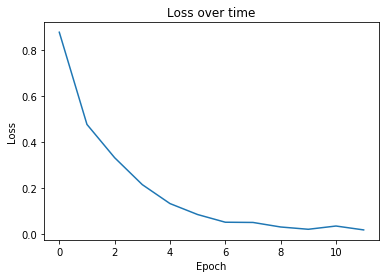

In [19]:
plt.plot(range(n_epochs), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over time')
plt.show()